In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score, average_precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25_only.shp")
lsoa_label.shape

(4835, 9)

In [4]:
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [20]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")

In [9]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [77]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.shape)

(188278, 401)


In [78]:
text.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)

In [90]:
text = text.dropna(subset=["wgs84_polygon.coordinates"])

In [91]:
text = text.dropna(subset=["polygon.geometries"])

In [92]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()

In [93]:
print(type(text_valid["wgs84_polygon.coordinates"].iloc[0]))
print(text_valid["wgs84_polygon.coordinates"].iloc[0])

<class 'str'>
[[[-0.330153, 51.480892], [-0.330154, 51.480865], [-0.330197, 51.480866], [-0.330196, 51.480893], [-0.330153, 51.480892]]]


In [94]:
import ast

text_valid["coords_list"] = text_valid["wgs84_polygon.coordinates"].apply(ast.literal_eval)

In [95]:
print(type(text_valid["coords_list"].iloc[0]))

<class 'list'>


In [96]:
from shapely.geometry import Polygon

text_valid["geometry"] = text_valid["coords_list"].apply(lambda coords: Polygon(coords[0]))

In [97]:
import geopandas as gpd

gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [98]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [99]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [100]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "gentrified", 
                                                                            "pop_growth_rate", "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [101]:
subset = joined_centroid[joined_centroid["LSOA code"] == "E01032739"]
print(subset)

                                                site_name decision_date  \
449         Unit 2\r100 Cannon Street\rLondon\rEC4N 6EU\r    2016-03-17   
1045                                      Centurion House    2016-01-14   
2390                                        Street Record    2016-02-24   
3097    100 Liverpool Street & 8 - 12 Broadgate\rLondo...    2016-10-31   
4095                                        Street Record    2015-12-10   
...                                                   ...           ...   
173944                  135 Bishopsgate\nLondon\nEC2M 3TP    2020-01-16   
173959          Unit 7-8 \n167 Moorgate\nLondon\nEC2M 6XQ    2019-10-01   
173989               133 Middlesex Street\nLondon\nE1 7JF    2019-12-03   
174006  Octagon Mall And Land Adjacent To 100 Liverpoo...    2020-02-25   
180494   Outside 69 Leadenhall Street\rLondon\rEC3A 2BG\r    2019-10-31   

        valid_date                                 polygon.geometries  \
449     2015-12-11  [{'coo

In [141]:
subset.to_csv("data/E01032739_application.csv")

In [102]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()

In [103]:
unmatched = joined_cleaned[joined_cleaned["gentrified"].isna()]
print(len(unmatched))

0


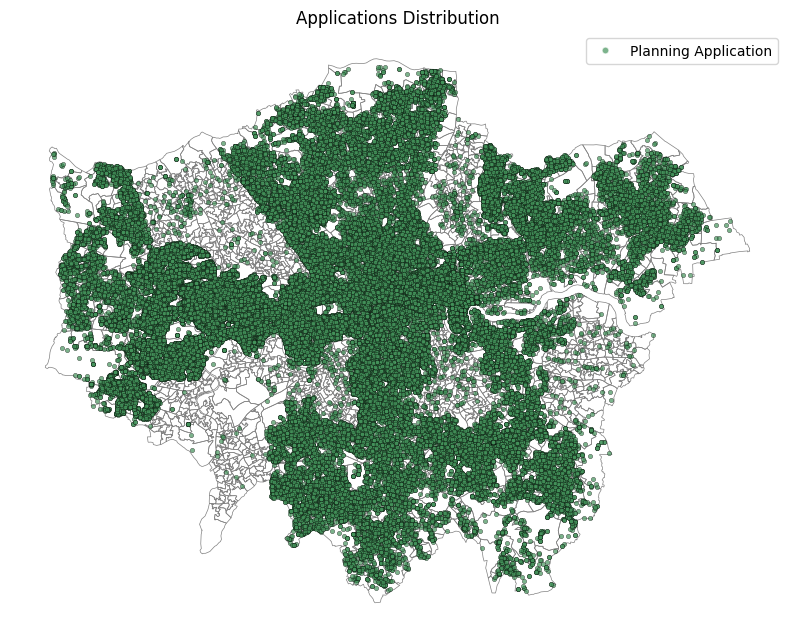

In [171]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# map the unlabelled points
fig, ax = plt.subplots(figsize=(10, 10))
lsoa_label.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
joined_cleaned.set_geometry("centroid").plot(
    ax=ax, 
    color="#44935b", 
    edgecolor='black',  # 添加白色轮廓
    linewidth=0.3,     # 轮廓线宽
    markersize=10,      # 适当增大点的大小
    alpha=0.7          # 提高透明度
)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Planning Application',
           markerfacecolor='#44935b', markersize=5, alpha=0.7)
]

ax.legend(handles=legend_elements, loc='upper right')
plt.title("Applications Distribution")
plt.axis("off")
plt.show()

In [109]:
joined_cleaned['gentrified'].value_counts()

gentrified
False    120307
True      15641
Name: count, dtype: int64

In [115]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

In [116]:
print(lsoa_counts.head(20))

    LSOA code  application_count
0   E01000001                 44
1   E01000002                 78
2   E01000003                 33
3   E01000005                 96
4   E01000006                  1
5   E01000007                  9
6   E01000008                  1
7   E01000009                  6
8   E01000010                 16
9   E01000011                  6
10  E01000012                  4
11  E01000013                  8
12  E01000014                  5
13  E01000015                  2
14  E01000016                  8
15  E01000017                  8
16  E01000018                  4
17  E01000019                  3
18  E01000020                  6
19  E01000021                  8


In [117]:
max_row = lsoa_counts.loc[lsoa_counts["application_count"].idxmax()]
print(max_row)

LSOA code            E01032739
application_count          876
Name: 3948, dtype: object


In [118]:
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')

In [119]:
print(lsoa_label["application_count"].head(5))

0    44.0
1    78.0
2    33.0
3    96.0
4     1.0
Name: application_count, dtype: float64


In [132]:
print(lsoa_label.shape)

(4835, 27)


In [120]:
print(lsoa_label["application_count"].max())

876.0


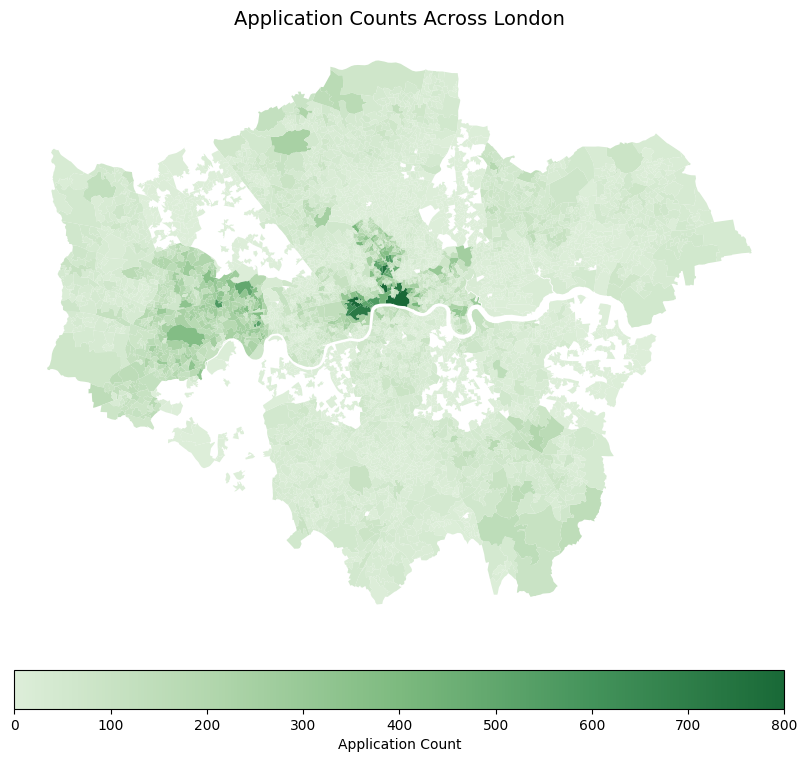

In [150]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(10, 10))

# 定义自己的颜色序列（示例：蓝->青->绿）
my_colors = ["#ddeed9", "#b3d7ae", "#7dba7f", "#44935b", "#196937"]

# 创建自定义色带
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', my_colors)

# 绘制地图
lsoa_plot = lsoa_label.plot(
    column='application_count', 
    cmap=custom_cmap,  # 使用自定义色带
    vmin=1,
    vmax=500,
    ax=ax,
    legend=False
)

# 创建横向 colorbar
sm = mpl.cm.ScalarMappable(cmap=custom_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=800))
sm._A = []  # 空数组占位
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Application Count')

ax.set_title("Application Counts Across London", fontsize=14)
ax.axis("off")
plt.show()


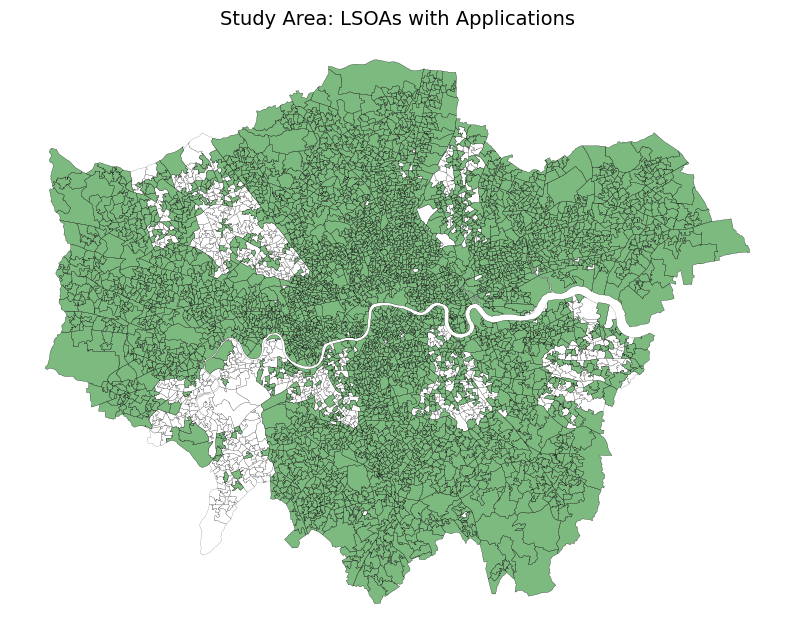

In [ ]:
import matplotlib.pyplot as plt

# 筛选出 application_count > 0 的 LSOA
lsoa_study = lsoa_label[lsoa_label['application_count'] > 0]

fig, ax = plt.subplots(figsize=(10, 10))

# 可以选择填充颜色，增强视觉效果
lsoa_study.plot(ax=ax, color='#7dba7f', edgecolor='black', linewidth=0.1)

# 绘制轮廓
lsoa_label.boundary.plot(ax=ax, color='black', linewidth=0.1)



ax.set_title("Study Area: LSOAs with Applications", fontsize=14)
ax.axis("off")
plt.show()

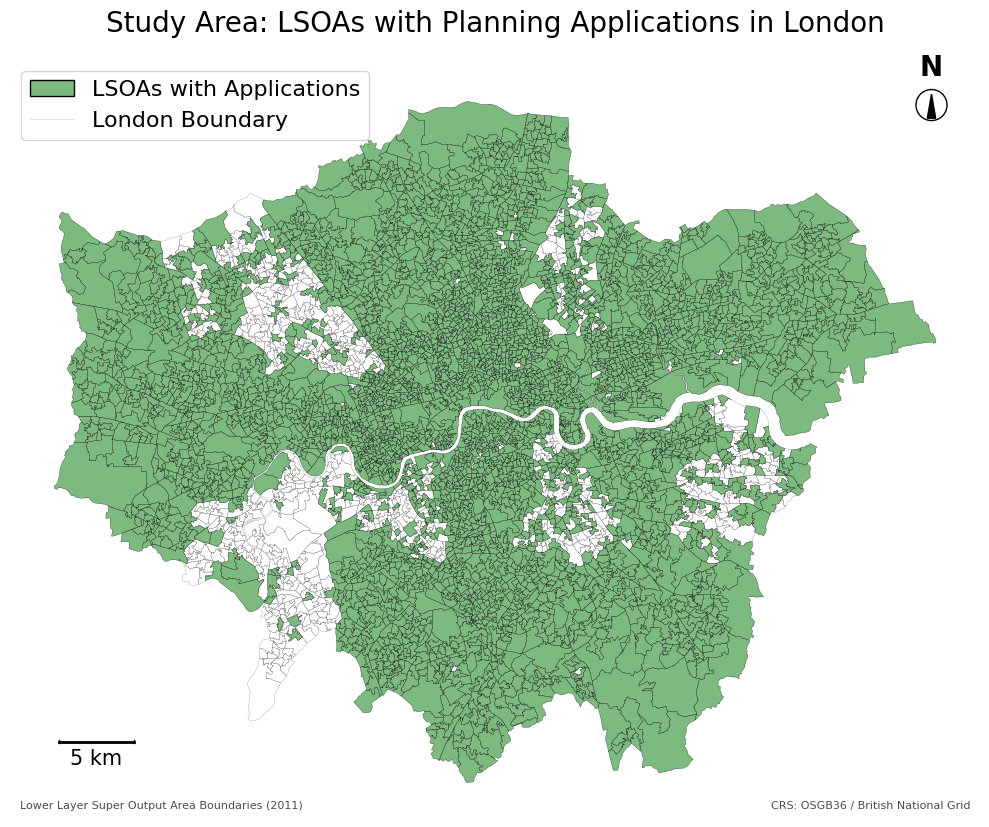

In [195]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np

# 筛选出 application_count > 0 的 LSOA
lsoa_study = lsoa_label[lsoa_label['application_count'] > 0]

fig, ax = plt.subplots(figsize=(10, 10))

# 绘制研究区域
lsoa_study.plot(ax=ax, color='#7dba7f', edgecolor='black', linewidth=0.1)

# 绘制整个伦敦的轮廓（浅灰色）
lsoa_label.boundary.plot(ax=ax, color='black', linewidth=0.1)

# 设置标题
ax.set_title("Study Area: LSOAs with Planning Applications in London", fontsize=20, pad=20)

# 关闭坐标轴
ax.axis("off")

# 添加图例说明
legend_elements = [
    patches.Patch(facecolor='#7dba7f', edgecolor='black', label='LSOAs with Applications'),
    Line2D([0], [0], color='lightgray', linewidth=0.5, label='London Boundary')
]
ax.legend(handles=legend_elements, fontsize=16, loc='upper left', frameon=True)

# ================== 添加指北针 ==================
# 计算指北针位置（右上角）
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
north_x = x_max - 0.05 * (x_max - x_min)  # 距离右边5%
north_y = y_max - 0.05 * (y_max - y_min)  # 距离上边5%

# 计算尺寸因子（基于地图大小）
size_factor = max((x_max - x_min), (y_max - y_min)) * 0.02

# 绘制专业指北针（完美对齐）
# 1. 绘制圆环
circle_radius = size_factor * 0.8
circle = plt.Circle((north_x, north_y), circle_radius, 
                   fill=False, edgecolor='black', linewidth=1)
ax.add_artist(circle)

# 2. 绘制完美对齐的三角形箭头
# 计算三角形尺寸（确保底部接触圆环）
triangle_height = circle_radius * 0.9  # 三角形高度为圆环半径的90%
triangle_width = triangle_height * 0.6  # 三角形宽度为高度的60%

# 计算三角形顶点坐标（确保底部接触圆环）
# 顶部顶点（位于圆环上部）
top_point = (north_x, north_y + circle_radius * 0.7)
# 底部顶点（正好接触圆环底部）
bottom_y = north_y - circle_radius * 0.85  # 调整底部位置
left_point = (north_x - triangle_width/2, bottom_y)
right_point = (north_x + triangle_width/2, bottom_y)

# 创建三角形多边形
triangle = patches.Polygon(
    [top_point, left_point, right_point],
    closed=True,
    facecolor='black',
    edgecolor='black'
)
ax.add_patch(triangle)

# 3. 添加精确对齐的"N"标签
ax.text(north_x, north_y + circle_radius * 1.5, 'N', 
        fontsize=20, weight='bold', ha='center', va='bottom',
        fontfamily='sans-serif')

# 4. 添加辅助线（可选，用于调试位置）
# ax.plot([north_x, north_x], [north_y - circle_radius, north_y + circle_radius], 
#         color='red', linewidth=0.5, alpha=0.3)
# ax.plot([north_x - circle_radius, north_x + circle_radius], [north_y, north_y], 
#         color='red', linewidth=0.5, alpha=0.3)
# ================== 添加比例尺 ==================
# 计算比例尺位置（左下角）
scale_x = x_min + 0.05 * (x_max - x_min)  # 距离左边5%
scale_y = y_min + 0.1 * (y_max - y_min)  # 距离下边5%

# 设置比例尺长度（假设1单位=1km）
scale_length_km = 5  # 5公里
scale_length = scale_length_km * 1000  # 转换为米（如果坐标单位是米）

# 绘制比例尺
scale_line = ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], 
                    color='black', linewidth=2)[0]

# 添加比例尺标签
ax.text(scale_x + scale_length/2, scale_y - 0.01*(y_max-y_min), 
        f'{scale_length_km} km', 
        ha='center', va='top', fontsize=15)

# 在比例尺两端添加刻度标记
ax.plot([scale_x, scale_x], [scale_y - 0.002*(y_max-y_min), scale_y + 0.002*(y_max-y_min)], 
        color='black', linewidth=1)
ax.plot([scale_x + scale_length, scale_x + scale_length], 
        [scale_y - 0.002*(y_max-y_min), scale_y + 0.002*(y_max-y_min)], 
        color='black', linewidth=1)

# 添加数据来源说明
ax.text(0.01, 0.01, 'Lower Layer Super Output Area Boundaries (2011)',
        transform=ax.transAxes, fontsize=8, alpha=0.7)
        
# 添加坐标系信息
crs_name = lsoa_label.crs.name if lsoa_label.crs else "Unknown"
ax.text(0.99, 0.01, f'CRS: {crs_name}',
        transform=ax.transAxes, fontsize=8, alpha=0.7, ha='right')

plt.tight_layout()
plt.savefig('study_area_map.png', bbox_inches='tight')
plt.show()

In [196]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd

# 筛选出 application_count > 0 的 LSOA
lsoa_study = lsoa_label[lsoa_label['application_count'] > 0]

# 创建图形
fig, ax = plt.subplots(figsize=(12, 12))

# 1. 绘制研究区域（使用半透明填充）
lsoa_study.plot(ax=ax, color='#7dba7f', alpha=0.7, edgecolor='black', linewidth=0.3)

# 2. 绘制整个伦敦的轮廓（深灰色）
lsoa_label.boundary.plot(ax=ax, color='#333333', linewidth=0.5)

# 3. 添加专业底图 - 使用CartoDB的Positron底图
# 注意：contextily需要数据在Web Mercator投影(EPSG:3857)下
# 如果数据不在该投影，需要转换
if lsoa_study.crs != 3857:
    lsoa_study_web = lsoa_study.to_crs(epsg=3857)
    lsoa_label_web = lsoa_label.to_crs(epsg=3857)
else:
    lsoa_study_web = lsoa_study
    lsoa_label_web = lsoa_label

# 获取底图的边界范围
minx, miny, maxx, maxy = lsoa_study_web.total_bounds

# 添加底图 - 使用CartoDB Positron（无标签版）
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                attribution_size=8,
                zoom='auto')  # 自动选择合适缩放级别

# 4. 添加专业指北针 - 使用cartopy
try:
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import cartopy.feature as cfeature
    
    # 添加指北针
    ax.add_feature(cfeature.NorthArrow(
        location=(0.95, 0.95),  # 右上角
        size=30,  # 大小
        edgecolor='black',
        facecolor='black',
        zorder=10
    ))
except ImportError:
    print("Cartopy not installed, using simple north arrow")
    # 简单的替代方案
    ax.text(0.95, 0.93, 'N', transform=ax.transAxes, 
            fontsize=20, weight='bold', ha='center', va='center')

# 5. 添加专业比例尺
scalebar = ScaleBar(
    dx=1,  # 每个数据单位代表1米
    units="m", 
    dimension="si-length", 
    length_fraction=0.25,  # 占地图宽度的25%
    location='lower left',
    pad=0.5,
    border_pad=0.5,
    sep=3,
    frameon=True,
    color='black',
    box_color='white',
    box_alpha=0.7
)
ax.add_artist(scalebar)

# 6. 添加图例说明
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#7dba7f', edgecolor='black', alpha=0.7, label='LSOAs with Applications'),
    Patch(facecolor='none', edgecolor='#333333', linewidth=0.5, label='London Boundary')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, framealpha=0.8)

# 7. 添加标题和元数据
ax.set_title("Study Area: LSOAs with Planning Applications", fontsize=18, pad=20, weight='bold')

# 添加数据来源说明
ax.text(0.01, 0.01, 'Data: Office for National Statistics (2022) | Basemap: CartoDB Positron',
        transform=ax.transAxes, fontsize=9, alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

# 添加坐标系信息
crs_info = f"CRS: {lsoa_study_web.crs.name}" if lsoa_study_web.crs else "CRS: Unknown"
ax.text(0.99, 0.01, crs_info,
        transform=ax.transAxes, fontsize=9, alpha=0.8, ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

# 调整布局并保存
plt.tight_layout()
plt.savefig('professional_study_area_map.png', dpi=300, bbox_inches='tight')
plt.show()

ModuleNotFoundError: No module named 'contextily'